# Demonstration code for "Building a complete RL system" lecture",

## Introduction
This code demonstrates our implementation of SARSA for the [Taxi-v3](https://gym.openai.com/envs/Taxi-v3/) environment and serves as additional information to go alongside the "Building a complete Rl system" lecture.
The lecture is delivered as part of the [Reinforcement Learning (2021) course](http://www.drps.ed.ac.uk/20-21/dpt/cxinfr11010.htm) at the University of Edinburgh.



## Dependencies
To run the python code, you will need [OpenAI Gym](https://gym.openai.com) which can be installed using

    pip install gym

Further dependencies are [Matplotlib](https://matplotlib.org/) and [NumPy](https://numpy.org/) which can be installed with

	pip install matplotlib
	pip install numpy
    
    
## Let's get to know the Environment - Taxi-v3
**t=0** | **t=1** | **t=2**
:-: | :-: | :-:
![t0_illustration](./media/Taxi-v3/Taxi-v3_1.png) | ![t1_illustration](./media/Taxi-v3/Taxi-v3_2.png) | ![t2_illustration](./media/Taxi-v3/Taxi-v3_3.png)


### Goal: Pickup passenger and drop it off at destination

### Observations: int $\in [0, 499]$ encoding
- Taxi location (row and column)
- Passenger location (index)
- Destination (index)

### Actions: 6 discrete actions
- 0: move **South**
- 1: move **North**
- 2: move **East**
- 3: move **West**
- 4: **Pick**-up passenger
- 5: **Drop**-off passenger

### Reward:
- $+20$ for successful delivery
- $-10$ for illegal move (attempting to pickup passenger on field without passenger or trying to drop off a passenger without having the passenger inside the taxi)
- $-1$ at each timestep otherwise

### Gridworld:
- Dimension: 5x5
- Always identical
- 4 positions where the passenger and destination can be initialised for the episode (randomised for each episode)

## Human Interface
In order to get familiar with the task, we first create an interface such that a human player can play the game. In the end, playing is fun! And it helps us to understand the task at hand. So let's go ...

In [1]:
def str_to_action(string: str) -> int:
    """
    Transfer string to action id (for Taxi-v3)

    :param string (str): input string
    :return (int): action id for Taxi-v3
    """
    if string == "S":
        return 0
    elif string == "W":
        return 1
    elif string == "D":
        return 2
    elif string == "A":
        return 3
    elif string == "J":
        return 4
    elif string == "K":
        return 5
    else:
        raise ValueError(f"Unknown name {string}!")


        
def get_input():
    act = input("Choose action [WASD + J (Pickup) / K (Dropoff) | STOP]")
    if act == "STOP":
        return -1
    else:
        return str_to_action(act)

In [46]:
import gym

def human_player(env: gym.Env):
    """
    Play Taxi-v3 as a human player with WASD + JK keys
    """
    print("Use WASD to move in the environment, use J and K to Pickup or Dropoff the passenger and end game with STOP or keyboard interrupt (Ctrl-C)")
    env.reset()
    env.render()
    
    ep_return = 0
    while True:
        act = get_input()
        
        if act == -1:
            return
        _, rew, done, _ = env.step(act)
        ep_return += rew
        env.render()
        if done:
            if ep_return > 0:
                print(f"EPISODE FINISHED WITH RETURN {ep_return} - SOLVED")
            else:
                print(f"EPISODE FINISHED WITH RETURN {ep_return} - FAILED")
            env.reset()
            ep_return = 0
            env.render()
    return

In [47]:
env = gym.make('Taxi-v3')
human_player(env)
env.close()

Use WASD to move in the environment, use J and K to Pickup or Dropoff the passenger and end game with STOP or keyboard interrupt (Ctrl-C)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Choose action [WASD + J (Pickup) / K (Dropoff) | STOP]A
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Choose action [WASD + J (Pickup) / K (Dropoff) | STOP]A
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Choose action [WASD + J (Pickup) / K (Dropoff) | STOP]A
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Choose action [WASD + J (Pickup) / K (Dropoff) | STOP]A
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Choose action [WASD + J (Pickup) / K (Dropoff) | STOP]S
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Choose action [WASD + J (Pickup

## SARSA Agent
Now after understanding the task of FrozenLake, let's implement an agent for the on-policy TD control algorithm, also called SARSA. If you need a revision, have a look at [lecture 6  on Temporal Difference Learning](https://www.learn.ed.ac.uk/bbcswebdav/pid-4067850-dt-content-rid-11604420_1/xid-11604420_1) (Slides 15 - 17) or take a look at [section 6.4 in the RL book](http://www.incompleteideas.net/book/RLbook2018.pdf##page=153) on the SARSA method.

In [29]:
from collections import defaultdict
import random
from typing import DefaultDict

import numpy as np


class SARSA():
    """Base class for SARSA agent

    :attr n_acts (int): number of actions
    :attr gamma (float): discount factor gamma
    :attr epsilon (float): epsilon hyperparameter for epsilon-greedy policy
    :attr alpha (float): learning rate alpha for updates
    :attr q_table (DefaultDict): table for Q-values mapping (OBS, ACT) pairs of observations
        and actions to respective Q-values
    """

    def __init__(
            self,
            num_acts: int,
            gamma: float,
            epsilon: float = 0.9,
            alpha: float = 0.1
        ):
        """Constructor for SARSA agent

        Initializes basic variables of the agent namely the epsilon, learning rate and discount
        rate.

        :param num_acts (int): number of possible actions
        :param gamma (float): discount factor (gamma)
        :param epsilon (float): initial epsilon for epsilon-greedy action selection
        :param alpha (float): learning rate alpha
        """
        self.n_acts: int = num_acts
        self.gamma: float = gamma
        self.epsilon: float = epsilon
        self.alpha: float = alpha

        self.q_table: DefaultDict = defaultdict(lambda: 0)

    def act(self, obs: np.ndarray) -> int:
        """Epsilon-greedy action selection 

        :param obs (np.ndarray of float with dim (observation size)):
            received observation representing the current environmental state
        :return (int): index of selected action
        """
        act_vals = [self.q_table[(obs, act)] for act in range(self.n_acts)]
        max_val = max(act_vals)
        max_acts = [idx for idx, act_val in enumerate(act_vals) if act_val == max_val]

        if random.random() < self.epsilon:
            return random.randint(0, self.n_acts - 1)
        else:
            return random.choice(max_acts)

    def learn(
            self,
            obs: np.ndarray,
            action: int,
            reward: float,
            n_obs: np.ndarray,
            n_action: int,
            done: bool
        ) -> float:
        """Updates the Q-table based on agent experience

        :param obs (np.ndarray of float with dim (observation size)):
            received observation representing the current environmental state
        :param action (int): index of applied action
        :param reward (float): received reward
        :param n_obs (np.ndarray of float with dim (observation size)):
            received observation representing the next environmental state
        :param done (bool): flag indicating whether a terminal state has been reached
        :return (float): updated Q-value for current observation-action pair
        """
        target_value = reward + self.gamma * (1 - done) * self.q_table[(n_obs, n_action)]
        self.q_table[(obs, action)] += self.alpha * (
            target_value - self.q_table[(obs, action)]
        )
        return self.q_table[(obs, action)]

    def schedule_hyperparameters(self, timestep: int, max_timestep: int):
        """Updates the hyperparameters

        This function is called before every episode and allows you to schedule your
        hyperparameters.

        :param timestep (int): current timestep at the beginning of the episode
        :param max_timestep (int): maximum timesteps that the training loop will run for
        """
        self.epsilon = 1.0-(min(1.0, timestep/(0.07*max_timestep)))*0.95

## Evaluation Tools
Besides learning Q-values to solve FrozenLake, we would like to observe the progress during our evaluation and visualise our final, learned policy. For this purpose, we implement different visualisation tools to look at our results.

### Text visualisation
First, we implement visualisation of our final policy and print the Q-values obtained during learning.

In [30]:
def act_to_str(act: int) -> str:
    """
    Map actions (of Taxi-v3 environment) to interpretable symbols corresponding to directions

    :param act (int): action to map to string
    :return (str): interpretable action name
    """
    if act == 0:
        return "S"
    elif act == 1:
        return "N"
    elif act == 2:
        return "E"
    elif act == 3:
        return "W"
    elif act == 4:
        return "P"
    elif act == 5:
        return "D"
    else:
        raise ValueError("Invalid action value")

def visualise_q_table(q_table, offset=""):
    """
    Print q_table in human-readable format

    :param q_table (Dict): q_table in form of a dict mapping (observation, action) pairs to
        q-values
    :param offset (str): string to put in front of all prints
    """
    for key in sorted(q_table.keys()):
        obs, act = key
        act_name = act_to_str(act)
        q_value = q_table[key]
        print(f"{offset}Pos={obs}\tAct={act_name}\t->\t{q_value}")

### Plot visualisation
Now, we implement visualisation of our training progress by generating plots showing the mean rewards obtained during evaluations. Besides rewards, we also want to visualise the $\epsilon$-decay to make sure, this exploration parameter decays nicely as expected.

It is good practise to not just visualise actual rewards obtained during training, but also plot standard deviations of rewards obtained over multiple training runs. This way, we can not just observe the actual performance of our RL algorithm, but keep track of its variance. An algorithm that performs great when we get lucky, but is vary variant might not be that great after all!
Don't fall in the pitfall of "feeling safe" whenever your algorithm performs well in a singular evaluation run!

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-darkgrid")
plt.rcParams.update({"font.size": 15})


def plot_timesteps(eval_freq: int, values: np.ndarray, stds: np.ndarray, xlabel: str, ylabel: str, legend_name: str):
    """
    Plot values with respect to timesteps
    
    :param eval_freq (int): evaluation frequency
    :param values (np.ndarray): numpy array of values to plot as y values
    :param std (np.ndarray): numpy array of stds of y values to plot as shading
    :param xlabel (str): label of x-axis
    :param ylabel (str): label of y-axis
    :param legend_name (str): name of algorithm
    """
    x_values = eval_freq + np.arange(len(values)) * eval_freq
    plt.plot(x_values, values, "-", alpha=0.7, label=f"{legend_name}")
    plt.fill_between(
        x_values,
        values - stds,
        values + stds,
        alpha=0.2,
        antialiased=True,
    )
    plt.legend(loc="best")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=0.3)

## Training and Evaluation code
This is the actual code to train and evaluate our SARSA implementation.
We execute a pre-defined amount of episodes (*total_eps*) for training on our agent and evaluate the performance every *eval_freq* episodes. For each evaluation, we execute not just one, but *eval_episodes* episodes, and store the mean performance obtained as well as its standard deviation. This allows us to nicely plot performance after the entire training.

Notice, that we set $\epsilon$ to 0 for evaluations! Why is this a good idea? Think about it! (What do we care about in evaluations and why do we use $\epsilon$-greedy policies in the first place?)

In [32]:
import gym
import numpy as np
from time import sleep


def evaluate(env, config, q_table, render=False):
    """
    Evaluate configuration of SARSA on given environment initialised with given Q-table

    :param env (gym.Env): environment to execute evaluation on
    :param config (Dict[str, float]): configuration dictionary containing hyperparameters
    :param q_table (Dict[(Obs, Act), float]): Q-table mapping observation-action to Q-values
    :param render (bool): flag whether evaluation runs should be rendered
    :return (float, float, int): mean and standard deviation of return received over episodes, number
        of negative returns
    """
    eval_agent = SARSA(
            num_acts=env.action_space.n,
            gamma=config["gamma"],
            epsilon=0.0, 
            alpha=config["alpha"],
    )
    eval_agent.q_table = q_table
    episodic_returns = []
    for eps_num in range(config["eval_episodes"]):
        obs = env.reset()
        if render:
            env.render()
            sleep(1)
        episodic_return = 0
        done = False

        steps = 0
        while not done and steps <= config["max_episode_steps"]:
            steps += 1
            act = eval_agent.act(obs)
            n_obs, reward, done, info = env.step(act)
            if render:
                env.render()
                sleep(1)

            episodic_return += reward

            obs = n_obs

        episodic_returns.append(episodic_return)

    mean_return = np.mean(episodic_returns)
    std_return = np.std(episodic_returns)
    negative_returns = sum([ret < 0 for ret in episodic_returns])
    return mean_return, std_return, negative_returns


def train(env, config, output=True):
    """
    Train and evaluate SARSA on given environment with provided hyperparameters

    :param env (gym.Env): environment to execute evaluation on
    :param config (Dict[str, float]): configuration dictionary containing hyperparameters
    :param output (bool): flag whether mean evaluation performance should be printed
    :return (List[float], List[float], List[float], Dict[(Obs, Act)]):
        list of means and standard deviations of evaluation returns, list of epislons, final Q-table
    """
    agent = SARSA(
            num_acts=env.action_space.n,
            gamma=config["gamma"],
            epsilon=config["epsilon"],
            alpha=config["alpha"],
    )

    step_counter = 0
    # 100 as estimate of max steps to take in an episode
    max_steps = config["total_eps"] * config["max_episode_steps"]
    
    evaluation_return_means = []
    evaluation_return_stds = []
    evaluation_epsilons = []

    for eps_num in range(config["total_eps"]):
        obs = env.reset()
        episodic_return = 0
        steps = 0
        done = False

        # take first action
        act = agent.act(obs)

        while not done and steps < config["max_episode_steps"]:
            n_obs, reward, done, info = env.step(act)
            step_counter += 1
            episodic_return += reward

            agent.schedule_hyperparameters(step_counter, max_steps)
            n_act = agent.act(n_obs)
            agent.learn(obs, act, reward, n_obs, n_act, done)

            obs = n_obs
            act = n_act

        if eps_num % config["eval_freq"] == 0:
            mean_return, std_return, negative_returns = evaluate(
                    env,
                    config,
                    agent.q_table,
                    render=RENDER,
            )
            if output:
                print(f"EVALUATION: EP {eps_num} - MEAN RETURN {mean_return} +/- {std_return} ({negative_returns}/{config['eval_episodes']} failed episodes)")
            evaluation_return_means.append(mean_return)
            evaluation_return_stds.append(std_return)
            evaluation_epsilons.append(agent.epsilon)

    return evaluation_return_means, evaluation_return_stds, evaluation_epsilons, agent.q_table

### Configurations
These training configurations define hyperparameters as well main parameters of our training and allow us to easily change these in a single place. We will follow this structure for the following coursework of the RL course and hope it simplifies tuning while maintaining clean code structure.

Besides configurations, we also set a flag whether the environment should be rendered during evaluations. Feel free to set this flag to *True* to see our SARSA act in the FrozenLake environment during evaluations! Keep in mind that this will slow down training significantly, as we wait briefly after each step taken in an evaluation to make the progress readable.

Lastly, we define a set of random seeds here. They will be used to execute training multiple times and average performance over all runs. This is an essential step for meaningful evaluation for two reasons:

1. SARSA, as most RL methods, has random elements. E.g. $\epsilon$-greedy policies contain randomness which affects training progress. Therefore, we need to evaluate multiple times with different random seeds to be able to make strong claims about its actual performance. In the end, we might have just been lucky!
2. Setting such random seeds makes our evaluation reproducible as they make the "random behaviour deterministic", i.e. repeated execution of random code with identical set random seeds leads to the same results. Reproducibility is key for meaningful research and is sometimes lacking in research publications. Look at this article for more information on common pitfalls and some good practises to follow: https://www.nature.com/articles/d41586-019-01307-2?utm_source=fbk_nnc&utm_medium=social&utm_campaign=naturenews&sf211529604=1&fbclid=IwAR3u6IhK7C8Ure9_DTeyZowUGatygKDSBBf4dYy94T1s3Oqb7L9xSz6bkR0

In [34]:
CONFIG = {
    "total_eps": 10000,
    "max_episode_steps": 100,
    "eval_episodes": 100,
    "eval_freq": 500,
    "gamma": 0.99,
    "alpha": 1e-1,
    "epsilon": 0.9,
}

RENDER = False
SEEDS = 10

## Finally ... let's train and evaluate!
Here we will first train SARSA agents for each random seed and print the final policy as a table. Feel free to set *output=True* in the *train*-call to print intermediate evaluation results.

In [38]:
env = gym.make("Taxi-v3")

num_returns = CONFIG["total_eps"] // CONFIG["eval_freq"]

eval_returns = np.zeros((SEEDS, num_returns))
all_epsilons = np.zeros((SEEDS, num_returns))
q_tables = []
for i in range(SEEDS):
    print(f"Executing training for SARSA - run {i + 1}")
    env.seed(i * 100)
    returns, _, epsilons, q_table = train(env, CONFIG, output=False) # output=True for evaluation info
    returns = np.array(returns)
    epsilons = np.array(epsilons)
    eval_returns[i, :] = returns
    all_epsilons[i, :] = epsilons
    q_tables.append(q_table)

Executing training for SARSA - run 1
Executing training for SARSA - run 2
Executing training for SARSA - run 3
Executing training for SARSA - run 4
Executing training for SARSA - run 5
Executing training for SARSA - run 6
Executing training for SARSA - run 7
Executing training for SARSA - run 8
Executing training for SARSA - run 9
Executing training for SARSA - run 10


### Evaluation Plots
Besides executing training and printing the final policy, we also want to look at plots indicating the evaluation performance and $\epsilon$-decay

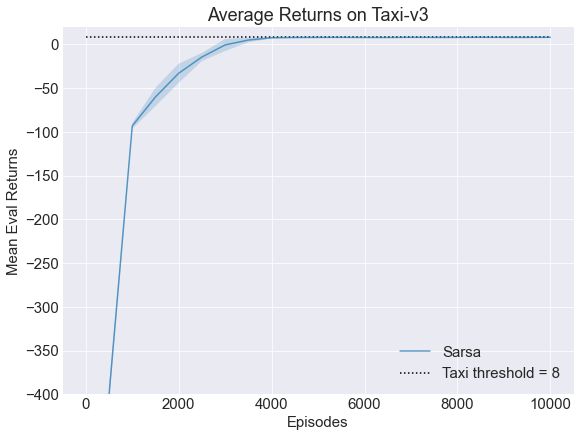

In [45]:
# plot returns
plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.title(f"Average Returns on Taxi-v3")

# draw goal line
x_min = 0
x_max = CONFIG["total_eps"]
plt.hlines(y=8, xmin=x_min, xmax=x_max, colors='k', linestyles='dotted', label="Taxi threshold = 8")
axes.set_ylim([-400,20])

returns_total = eval_returns.mean(axis=0)
returns_std = eval_returns.std(axis=0)
plot_timesteps(CONFIG["eval_freq"], returns_total, returns_std, "Episodes", "Mean Eval Returns", "Sarsa")
plt.show()

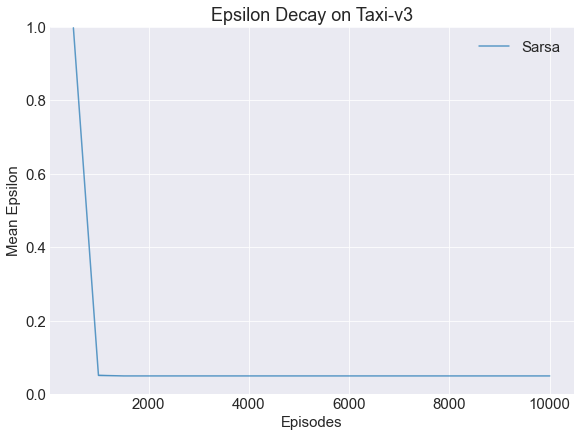

In [40]:
# plot epsilons
plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.title(f"Epsilon Decay on Taxi-v3")
axes.set_ylim([0,1])

epsilons_mean = all_epsilons.mean(axis=0)
epsilons_std = all_epsilons.std(axis=0)
plot_timesteps(CONFIG["eval_freq"], epsilons_mean, epsilons_std, "Episodes", "Mean Epsilon", "Sarsa")
plt.show()

In [42]:
#visualise Q-tables
for i, q_table in enumerate(q_tables):
    print(f"Q-table for run {i + 1}")
    visualise_q_table(q_table, offset="\t")

Q-table for run 1
	Pos=0	Act=S	->	0
	Pos=0	Act=N	->	0
	Pos=0	Act=E	->	0
	Pos=0	Act=W	->	0
	Pos=0	Act=P	->	0
	Pos=0	Act=D	->	0
	Pos=1	Act=S	->	-3.211972537601859
	Pos=1	Act=N	->	-0.8281032124155234
	Pos=1	Act=E	->	-4.301377796097673
	Pos=1	Act=W	->	-1.7488233985893458
	Pos=1	Act=P	->	6.817378997532742
	Pos=1	Act=D	->	-8.610511132906952
	Pos=2	Act=S	->	0.5657866373287826
	Pos=2	Act=N	->	1.3442167710502664
	Pos=2	Act=E	->	0.9882724277976563
	Pos=2	Act=W	->	2.179299293671657
	Pos=2	Act=P	->	10.501205134175738
	Pos=2	Act=D	->	-4.448718575580448
	Pos=3	Act=S	->	-0.9373123595283306
	Pos=3	Act=N	->	-1.2852672146943926
	Pos=3	Act=E	->	-1.601504259480874
	Pos=3	Act=W	->	-2.357200771549632
	Pos=3	Act=P	->	7.669904040695141
	Pos=3	Act=D	->	-7.1340564061375344
	Pos=4	Act=S	->	-6.48057599903505
	Pos=4	Act=N	->	-10.724913795932068
	Pos=4	Act=E	->	-10.684282223867521
	Pos=4	Act=W	->	-10.826318786988638
	Pos=4	Act=P	->	-11.00323980725521
	Pos=4	Act=D	->	-13.469721377652967
	Pos=6	Act=S	->	-10.471862252

	Pos=406	Act=D	->	-12.65840639466446
	Pos=407	Act=S	->	-8.69083095965982
	Pos=407	Act=N	->	-4.1847098339369495
	Pos=407	Act=E	->	-8.676947217269564
	Pos=407	Act=W	->	-8.81723819802054
	Pos=407	Act=P	->	-12.901380865203059
	Pos=407	Act=D	->	-12.214595462811086
	Pos=408	Act=S	->	2.239139655665473
	Pos=408	Act=N	->	0.867731588851534
	Pos=408	Act=E	->	1.2316907674689654
	Pos=408	Act=W	->	2.504581678789786
	Pos=408	Act=P	->	12.14620597727111
	Pos=408	Act=D	->	-5.311215808854861
	Pos=409	Act=S	->	-2.1419657655628153
	Pos=409	Act=N	->	-2.122892191156608
	Pos=409	Act=E	->	-1.6896891841576758
	Pos=409	Act=W	->	-1.2681171014552421
	Pos=409	Act=P	->	5.968071452225348
	Pos=409	Act=D	->	-8.402158102415578
	Pos=410	Act=S	->	0
	Pos=410	Act=N	->	0
	Pos=410	Act=E	->	0
	Pos=410	Act=W	->	0
	Pos=410	Act=P	->	0
	Pos=410	Act=D	->	0
	Pos=411	Act=S	->	-1.6215972863264478
	Pos=411	Act=N	->	0.15822792139754321
	Pos=411	Act=E	->	-1.0824634365705545
	Pos=411	Act=W	->	0.13476752225039634
	Pos=411	Act=P	->	7.019059

	Pos=213	Act=P	->	-11.221056256535329
	Pos=213	Act=D	->	-13.225384951572156
	Pos=214	Act=S	->	-9.180584370260245
	Pos=214	Act=N	->	-9.672077404505378
	Pos=214	Act=E	->	0.03485823945170688
	Pos=214	Act=W	->	-9.401484068053435
	Pos=214	Act=P	->	-11.947778247551627
	Pos=214	Act=D	->	-12.418251932998993
	Pos=216	Act=S	->	12.893810403706437
	Pos=216	Act=N	->	16.864671937512142
	Pos=216	Act=E	->	12.24449603015827
	Pos=216	Act=W	->	13.193322598068175
	Pos=216	Act=P	->	4.0110210655047975
	Pos=216	Act=D	->	5.608011596591656
	Pos=217	Act=S	->	4.384029594404073
	Pos=217	Act=N	->	3.2435988833362055
	Pos=217	Act=E	->	11.089030093524466
	Pos=217	Act=W	->	4.917164171292558
	Pos=217	Act=P	->	-1.4379369638203239
	Pos=217	Act=D	->	-2.066078285611565
	Pos=218	Act=S	->	16.93236110941931
	Pos=218	Act=N	->	12.931515386421001
	Pos=218	Act=E	->	12.412664732369226
	Pos=218	Act=W	->	12.805423339366538
	Pos=218	Act=P	->	4.877703026251398
	Pos=218	Act=D	->	4.601785532406762
	Pos=219	Act=S	->	-0.19286377658857623


	Pos=22	Act=E	->	-5.506934875553278
	Pos=22	Act=W	->	9.982064621002811
	Pos=22	Act=P	->	-10.568820092075933
	Pos=22	Act=D	->	-9.021961481803933
	Pos=23	Act=S	->	-5.7996577670658525
	Pos=23	Act=N	->	-5.921009149891682
	Pos=23	Act=E	->	-5.134548658351164
	Pos=23	Act=W	->	5.671004170969336
	Pos=23	Act=P	->	-9.241793684364637
	Pos=23	Act=D	->	-8.102626796611835
	Pos=24	Act=S	->	-5.080972544862246
	Pos=24	Act=N	->	-10.179937091255516
	Pos=24	Act=E	->	-10.260737285471835
	Pos=24	Act=W	->	-10.247838631125807
	Pos=24	Act=P	->	-14.430043584991715
	Pos=24	Act=D	->	-12.186944587204351
	Pos=26	Act=S	->	-4.96363199402346
	Pos=26	Act=N	->	-11.124643524926196
	Pos=26	Act=E	->	-11.163055733070006
	Pos=26	Act=W	->	-11.094628725743569
	Pos=26	Act=P	->	-13.356166914256537
	Pos=26	Act=D	->	-13.243055847999507
	Pos=27	Act=S	->	-0.7391558077535806
	Pos=27	Act=N	->	-7.7706247740399235
	Pos=27	Act=E	->	-7.858552828460388
	Pos=27	Act=W	->	-7.756450045684372
	Pos=27	Act=P	->	-13.350695023338465
	Pos=27	Act=D	->

	Pos=333	Act=E	->	-6.994144033873848
	Pos=333	Act=W	->	-6.925301083967724
	Pos=333	Act=P	->	-13.716374256387518
	Pos=333	Act=D	->	-10.834258179723744
	Pos=334	Act=S	->	-9.534394932853878
	Pos=334	Act=N	->	0.2568537973845947
	Pos=334	Act=E	->	-9.884415815216279
	Pos=334	Act=W	->	-9.909311223715127
	Pos=334	Act=P	->	-14.302441069250953
	Pos=334	Act=D	->	-13.471914802772629
	Pos=336	Act=S	->	-1.99314691561683
	Pos=336	Act=N	->	12.847929189312532
	Pos=336	Act=E	->	-2.0041100833921215
	Pos=336	Act=W	->	-2.3703917817277036
	Pos=336	Act=P	->	-2.9694770162475135
	Pos=336	Act=D	->	-7.6293025871913125
	Pos=337	Act=S	->	-1.7698571996744745
	Pos=337	Act=N	->	-1.7648078426646054
	Pos=337	Act=E	->	3.3973347056433063
	Pos=337	Act=W	->	-1.6559395520854734
	Pos=337	Act=P	->	-6.544649540532705
	Pos=337	Act=D	->	-7.9006173457309625
	Pos=338	Act=S	->	-3.788413482986046
	Pos=338	Act=N	->	11.235613800778818
	Pos=338	Act=E	->	-3.679715316261663
	Pos=338	Act=W	->	-3.6851684927775787
	Pos=338	Act=P	->	-10.4119

	Pos=141	Act=S	->	-2.7068077121919316
	Pos=141	Act=N	->	-10.241938727807444
	Pos=141	Act=E	->	-9.941019246859462
	Pos=141	Act=W	->	-10.38987711112515
	Pos=141	Act=P	->	-14.010639276866614
	Pos=141	Act=D	->	-13.334350501205599
	Pos=142	Act=S	->	3.6600419175870877
	Pos=142	Act=N	->	-5.736935276017288
	Pos=142	Act=E	->	-6.47774312336027
	Pos=142	Act=W	->	-5.7809915058325005
	Pos=142	Act=P	->	-11.711563088801439
	Pos=142	Act=D	->	-12.054073919134206
	Pos=143	Act=S	->	-0.10639774596139134
	Pos=143	Act=N	->	-8.941892310194147
	Pos=143	Act=E	->	-9.405149868698745
	Pos=143	Act=W	->	-9.469278165977922
	Pos=143	Act=P	->	-14.661249371058297
	Pos=143	Act=D	->	-9.8223107794517
	Pos=144	Act=S	->	-7.760468558134738
	Pos=144	Act=N	->	2.054053346259147
	Pos=144	Act=E	->	-7.2399895520085344
	Pos=144	Act=W	->	-5.721117079778903
	Pos=144	Act=P	->	-11.57070820715045
	Pos=144	Act=D	->	-10.567570927412019
	Pos=146	Act=S	->	-8.47164195024939
	Pos=146	Act=N	->	-8.407407647863973
	Pos=146	Act=E	->	0.38295985123

	Pos=482	Act=P	->	-13.042862687094338
	Pos=482	Act=D	->	-13.385516161604036
	Pos=483	Act=S	->	-10.016750628663479
	Pos=483	Act=N	->	-9.907589667716115
	Pos=483	Act=E	->	-9.932524200485242
	Pos=483	Act=W	->	-5.068661244992264
	Pos=483	Act=P	->	-15.34656895371008
	Pos=483	Act=D	->	-16.75432771898234
	Pos=484	Act=S	->	-7.541548056446245
	Pos=484	Act=N	->	0.3725574747154104
	Pos=484	Act=E	->	-7.177384002873792
	Pos=484	Act=W	->	-7.813748149763425
	Pos=484	Act=P	->	-12.764450424866792
	Pos=484	Act=D	->	-10.546388294018954
	Pos=486	Act=S	->	-8.651553318191493
	Pos=486	Act=N	->	-1.6122800069622814
	Pos=486	Act=E	->	-8.339715689932284
	Pos=486	Act=W	->	-8.671077225667647
	Pos=486	Act=P	->	-12.640587048115652
	Pos=486	Act=D	->	-12.158952134409114
	Pos=487	Act=S	->	-7.953575643206929
	Pos=487	Act=N	->	-2.414128539587844
	Pos=487	Act=E	->	-8.102710266860413
	Pos=487	Act=W	->	-7.842374212625607
	Pos=487	Act=P	->	-13.347539748336189
	Pos=487	Act=D	->	-9.769445350895205
	Pos=488	Act=S	->	-6.68942566

	Pos=301	Act=P	->	-10.885163818580596
	Pos=301	Act=D	->	-14.689418548070222
	Pos=302	Act=S	->	-5.618091912977573
	Pos=302	Act=N	->	6.427070295797968
	Pos=302	Act=E	->	-5.675842058950278
	Pos=302	Act=W	->	-5.749777697267311
	Pos=302	Act=P	->	-11.029841467471883
	Pos=302	Act=D	->	-7.69450379382322
	Pos=303	Act=S	->	-7.594298576909221
	Pos=303	Act=N	->	2.6525594717318017
	Pos=303	Act=E	->	-7.124907214534318
	Pos=303	Act=W	->	-7.715468698234043
	Pos=303	Act=P	->	-9.839675513575909
	Pos=303	Act=D	->	-12.471775336480787
	Pos=304	Act=S	->	-9.75332249101147
	Pos=304	Act=N	->	-3.951232881360307
	Pos=304	Act=E	->	-9.867919394684975
	Pos=304	Act=W	->	-9.811431998925464
	Pos=304	Act=P	->	-11.508706580642965
	Pos=304	Act=D	->	-11.86490326052214
	Pos=306	Act=S	->	-10.125167856259422
	Pos=306	Act=N	->	-4.46116795324471
	Pos=306	Act=E	->	-10.193348098054635
	Pos=306	Act=W	->	-10.186049544007366
	Pos=306	Act=P	->	-11.886832213712369
	Pos=306	Act=D	->	-11.951568345716783
	Pos=307	Act=S	->	-8.44719480455

	Pos=171	Act=D	->	-14.109784787553126
	Pos=172	Act=S	->	2.822802264161679
	Pos=172	Act=N	->	-7.297736333325142
	Pos=172	Act=E	->	-7.275792468698685
	Pos=172	Act=W	->	-6.539829687588852
	Pos=172	Act=P	->	-11.515709568797115
	Pos=172	Act=D	->	-13.932992023227394
	Pos=173	Act=S	->	5.264253200354135
	Pos=173	Act=N	->	-5.399614489766656
	Pos=173	Act=E	->	-5.767428758791045
	Pos=173	Act=W	->	-5.4433308205760325
	Pos=173	Act=P	->	-6.0016498618917025
	Pos=173	Act=D	->	-10.232304855858255
	Pos=174	Act=S	->	2.166820075222517
	Pos=174	Act=N	->	-7.702932341981209
	Pos=174	Act=E	->	-7.668647518063214
	Pos=174	Act=W	->	-7.263070779509547
	Pos=174	Act=P	->	-13.36723672694563
	Pos=174	Act=D	->	-10.388169639781559
	Pos=176	Act=S	->	10.312563483332422
	Pos=176	Act=N	->	-0.9682649696792895
	Pos=176	Act=E	->	-1.9968931351011459
	Pos=176	Act=W	->	-0.14793708397142247
	Pos=176	Act=P	->	-3.3213552724252398
	Pos=176	Act=D	->	-2.5548424881165133
	Pos=177	Act=S	->	11.710734278963011
	Pos=177	Act=N	->	11.9696841

	Pos=481	Act=P	->	-14.261139891259157
	Pos=481	Act=D	->	-13.344125506589917
	Pos=482	Act=S	->	-8.540328527963807
	Pos=482	Act=N	->	-3.4240162308147397
	Pos=482	Act=E	->	-8.676624066306767
	Pos=482	Act=W	->	-8.534556504599424
	Pos=482	Act=P	->	-11.831933947799346
	Pos=482	Act=D	->	-11.497970084196744
	Pos=483	Act=S	->	-10.919119275147072
	Pos=483	Act=N	->	-6.291065853580991
	Pos=483	Act=E	->	-10.553253687006691
	Pos=483	Act=W	->	-10.823963521466533
	Pos=483	Act=P	->	-15.49215026668589
	Pos=483	Act=D	->	-15.634554067941632
	Pos=484	Act=S	->	-7.361547514857362
	Pos=484	Act=N	->	-0.93982442212751
	Pos=484	Act=E	->	-7.460502584626054
	Pos=484	Act=W	->	-7.458528240654356
	Pos=484	Act=P	->	-11.295679651829623
	Pos=484	Act=D	->	-11.99066000106815
	Pos=486	Act=S	->	-7.987154427010078
	Pos=486	Act=N	->	-1.9991977577728586
	Pos=486	Act=E	->	-8.098802236421884
	Pos=486	Act=W	->	-7.862922331095301
	Pos=486	Act=P	->	-11.341648180869946
	Pos=486	Act=D	->	-10.986905836518416
	Pos=487	Act=S	->	-5.37346

	Pos=378	Act=E	->	-3.2722712670808023
	Pos=378	Act=W	->	2.036270871615799
	Pos=378	Act=P	->	-2.5389252481298077
	Pos=378	Act=D	->	-5.586857443446974
	Pos=379	Act=S	->	18.447257433512416
	Pos=379	Act=N	->	11.563437384459768
	Pos=379	Act=E	->	11.31111290145876
	Pos=379	Act=W	->	14.645654343593133
	Pos=379	Act=P	->	5.045038259846157
	Pos=379	Act=D	->	6.380230899321102
	Pos=381	Act=S	->	-10.042323442963225
	Pos=381	Act=N	->	-10.027857757910827
	Pos=381	Act=E	->	-10.061693035339925
	Pos=381	Act=W	->	-5.3413735685309955
	Pos=381	Act=P	->	-11.301424445233241
	Pos=381	Act=D	->	-11.052329643703477
	Pos=382	Act=S	->	-8.29306901114308
	Pos=382	Act=N	->	-8.212204847530758
	Pos=382	Act=E	->	-7.810385709410383
	Pos=382	Act=W	->	-0.48694274975735063
	Pos=382	Act=P	->	-10.866788114702016
	Pos=382	Act=D	->	-12.719149325139348
	Pos=383	Act=S	->	-9.651127439935422
	Pos=383	Act=N	->	-9.249809346547888
	Pos=383	Act=E	->	-9.612553896489285
	Pos=383	Act=W	->	-4.226612279984436
	Pos=383	Act=P	->	-12.732204337

	Pos=202	Act=W	->	-4.11781380485631
	Pos=202	Act=P	->	-9.299320412977698
	Pos=202	Act=D	->	-13.697889288062504
	Pos=203	Act=S	->	-7.446076676270471
	Pos=203	Act=N	->	3.8100885709569026
	Pos=203	Act=E	->	-7.426056775803582
	Pos=203	Act=W	->	-7.544038758052113
	Pos=203	Act=P	->	-9.795405317247866
	Pos=203	Act=D	->	-10.996816341024797
	Pos=204	Act=S	->	-9.572042358758019
	Pos=204	Act=N	->	-9.202039185650479
	Pos=204	Act=E	->	-2.4475109124433456
	Pos=204	Act=W	->	-9.314076038180225
	Pos=204	Act=P	->	-11.937252368476015
	Pos=204	Act=D	->	-14.020537912542743
	Pos=206	Act=S	->	-10.168663446763274
	Pos=206	Act=N	->	-10.3890197026554
	Pos=206	Act=E	->	-2.16317044585826
	Pos=206	Act=W	->	-10.430239487266665
	Pos=206	Act=P	->	-11.489694561505269
	Pos=206	Act=D	->	-11.504604551073383
	Pos=207	Act=S	->	-6.710862157561094
	Pos=207	Act=N	->	-6.720126866888405
	Pos=207	Act=E	->	1.9884662686709786
	Pos=207	Act=W	->	-7.394676925093394
	Pos=207	Act=P	->	-9.420884667529785
	Pos=207	Act=D	->	-8.99354151068

	Pos=11	Act=E	->	-9.831870872064753
	Pos=11	Act=W	->	-10.780457532877834
	Pos=11	Act=P	->	-16.49173428820387
	Pos=11	Act=D	->	-12.265702974085796
	Pos=12	Act=S	->	-3.990289571741455
	Pos=12	Act=N	->	-9.417863543523467
	Pos=12	Act=E	->	-9.284430460523929
	Pos=12	Act=W	->	-9.264499885891329
	Pos=12	Act=P	->	-10.79588782977274
	Pos=12	Act=D	->	-12.457471693657494
	Pos=13	Act=S	->	-7.625145372109344
	Pos=13	Act=N	->	-7.328312778488705
	Pos=13	Act=E	->	-0.19650436481486544
	Pos=13	Act=W	->	-7.140034867399147
	Pos=13	Act=P	->	-12.11006448268502
	Pos=13	Act=D	->	-10.36367235732471
	Pos=14	Act=S	->	-9.956437886375467
	Pos=14	Act=N	->	-10.026268628375623
	Pos=14	Act=E	->	-4.973311527447984
	Pos=14	Act=W	->	-10.123064364865412
	Pos=14	Act=P	->	-12.273524115203664
	Pos=14	Act=D	->	-11.329514021510427
	Pos=16	Act=S	->	13.3111065123318
	Pos=16	Act=N	->	14.439728415291585
	Pos=16	Act=E	->	15.83251150323261
	Pos=16	Act=W	->	17.155878051353273
	Pos=16	Act=P	->	7.515441215705212
	Pos=16	Act=D	->	19.999

	Pos=341	Act=S	->	-7.787158624416537
	Pos=341	Act=N	->	-0.753219883033073
	Pos=341	Act=E	->	-8.033666270476655
	Pos=341	Act=W	->	-7.118050427684466
	Pos=341	Act=P	->	-10.3018619909623
	Pos=341	Act=D	->	-11.636163561654605
	Pos=342	Act=S	->	-5.598821768328916
	Pos=342	Act=N	->	3.95869015589861
	Pos=342	Act=E	->	-5.6663612560253735
	Pos=342	Act=W	->	-3.813091866788495
	Pos=342	Act=P	->	-8.370577339956984
	Pos=342	Act=D	->	-10.262892787214899
	Pos=343	Act=S	->	-9.786040813069876
	Pos=343	Act=N	->	-0.13349934228717825
	Pos=343	Act=E	->	-9.8819185610866
	Pos=343	Act=W	->	-9.827908929039053
	Pos=343	Act=P	->	-12.20074385132256
	Pos=343	Act=D	->	-11.586279881354528
	Pos=344	Act=S	->	-9.309353052988799
	Pos=344	Act=N	->	-1.4364227856296066
	Pos=344	Act=E	->	-8.88907413241626
	Pos=344	Act=W	->	-9.344048154884133
	Pos=344	Act=P	->	-11.739167264764001
	Pos=344	Act=D	->	-12.677201795327028
	Pos=346	Act=S	->	-9.054524464267411
	Pos=346	Act=N	->	-1.1070119962396856
	Pos=346	Act=E	->	-9.0807760158889

	Pos=184	Act=D	->	-8.99270457010639
	Pos=186	Act=S	->	-4.643731237108793
	Pos=186	Act=N	->	4.603711415178096
	Pos=186	Act=E	->	-4.618565056937383
	Pos=186	Act=W	->	-5.534411372758917
	Pos=186	Act=P	->	-8.643238844299905
	Pos=186	Act=D	->	-9.472366300139367
	Pos=187	Act=S	->	-3.732930082284449
	Pos=187	Act=N	->	8.50654184664348
	Pos=187	Act=E	->	-2.715017100876776
	Pos=187	Act=W	->	-2.0779602376333193
	Pos=187	Act=P	->	-7.92445963553561
	Pos=187	Act=D	->	-7.090886424943935
	Pos=188	Act=S	->	0.4675146430763064
	Pos=188	Act=N	->	-9.973254833793781
	Pos=188	Act=E	->	-9.917752959387522
	Pos=188	Act=W	->	-9.967567723479256
	Pos=188	Act=P	->	-11.101272546381505
	Pos=188	Act=D	->	-15.385341754991444
	Pos=189	Act=S	->	-4.520098061808657
	Pos=189	Act=N	->	-10.183586137471076
	Pos=189	Act=E	->	-10.219049884389854
	Pos=189	Act=W	->	-10.623610488426024
	Pos=189	Act=P	->	-13.713263690867281
	Pos=189	Act=D	->	-15.689307565329958
	Pos=191	Act=S	->	-3.7133692277998973
	Pos=191	Act=N	->	-10.475017824757

## Let's do some hyperparameter gridsearch over the learning rate
Here we will train SARSA agents for each random seed and visualise mean returns for various learning rates $\alpha$ to visualise the impact of this hyperparameter.

Start training with lr=0.9
	Executing training for SARSA - run 1
	Executing training for SARSA - run 2
	Executing training for SARSA - run 3
	Executing training for SARSA - run 4
	Executing training for SARSA - run 5
	Executing training for SARSA - run 6
	Executing training for SARSA - run 7
	Executing training for SARSA - run 8
	Executing training for SARSA - run 9
	Executing training for SARSA - run 10


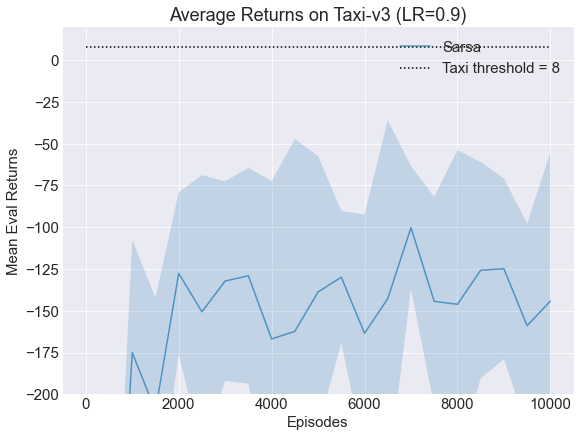

Start training with lr=0.7
	Executing training for SARSA - run 1
	Executing training for SARSA - run 2
	Executing training for SARSA - run 3
	Executing training for SARSA - run 4
	Executing training for SARSA - run 5
	Executing training for SARSA - run 6
	Executing training for SARSA - run 7
	Executing training for SARSA - run 8
	Executing training for SARSA - run 9
	Executing training for SARSA - run 10


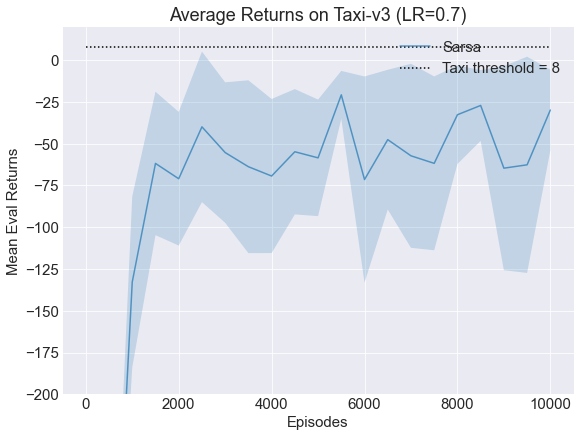

Start training with lr=0.5
	Executing training for SARSA - run 1
	Executing training for SARSA - run 2
	Executing training for SARSA - run 3
	Executing training for SARSA - run 4
	Executing training for SARSA - run 5
	Executing training for SARSA - run 6
	Executing training for SARSA - run 7
	Executing training for SARSA - run 8
	Executing training for SARSA - run 9
	Executing training for SARSA - run 10


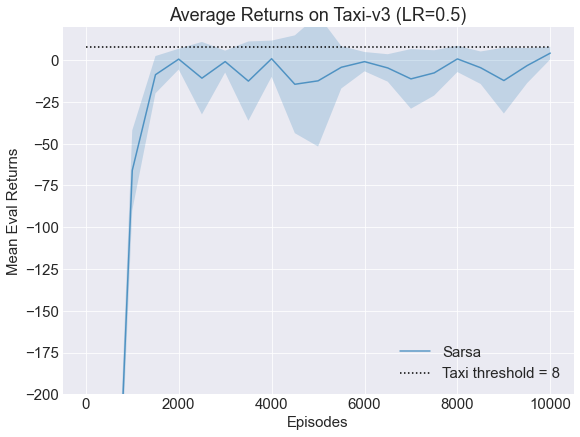

Start training with lr=0.3
	Executing training for SARSA - run 1
	Executing training for SARSA - run 2
	Executing training for SARSA - run 3
	Executing training for SARSA - run 4
	Executing training for SARSA - run 5
	Executing training for SARSA - run 6
	Executing training for SARSA - run 7
	Executing training for SARSA - run 8
	Executing training for SARSA - run 9
	Executing training for SARSA - run 10


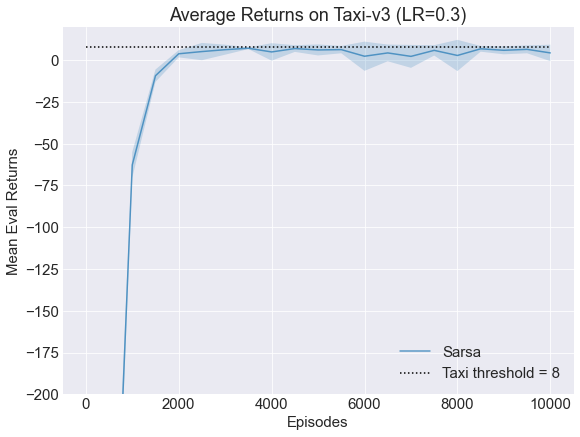

Start training with lr=0.2
	Executing training for SARSA - run 1
	Executing training for SARSA - run 2
	Executing training for SARSA - run 3
	Executing training for SARSA - run 4
	Executing training for SARSA - run 5
	Executing training for SARSA - run 6
	Executing training for SARSA - run 7
	Executing training for SARSA - run 8
	Executing training for SARSA - run 9
	Executing training for SARSA - run 10


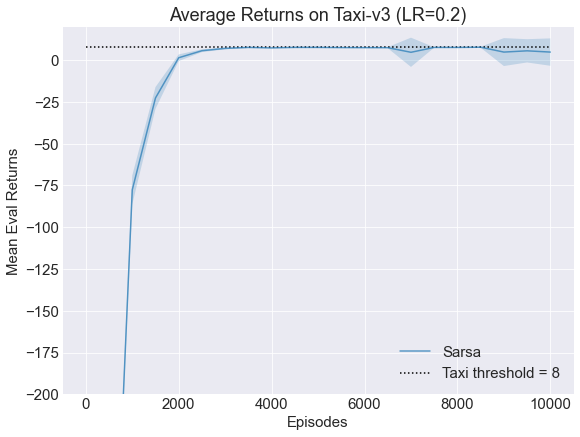

Start training with lr=0.1
	Executing training for SARSA - run 1
	Executing training for SARSA - run 2
	Executing training for SARSA - run 3
	Executing training for SARSA - run 4
	Executing training for SARSA - run 5
	Executing training for SARSA - run 6
	Executing training for SARSA - run 7
	Executing training for SARSA - run 8
	Executing training for SARSA - run 9
	Executing training for SARSA - run 10


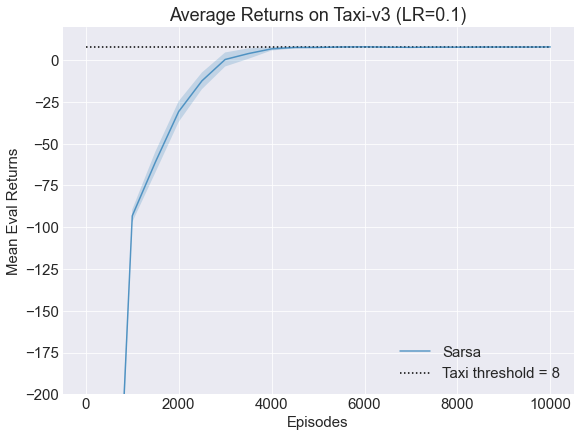

In [48]:
LRs = [0.9, 0.7, 0.5, 0.3, 0.2, 0.1]

# dict mapping lr to (returns_mean, returns_std)
results_dict = {}

for lr in LRs:
    print(f"Start training with lr={lr}")
    config = CONFIG
    config["alpha"] = lr
    env = gym.make("Taxi-v3")

    num_returns = config["total_eps"] // config["eval_freq"]

    eval_returns = np.zeros((SEEDS, num_returns))
    all_epsilons = np.zeros((SEEDS, num_returns))
    q_tables = []
    for i in range(SEEDS):
        print(f"\tExecuting training for SARSA - run {i + 1}")
        env.seed(i * 100)
        returns, _, epsilons, q_table = train(env, config, output=False) # output=True for evaluation info
        returns = np.array(returns)
        epsilons = np.array(epsilons)
        eval_returns[i, :] = returns
        all_epsilons[i, :] = epsilons
        q_tables.append(q_table)
    
    # plot returns for lr
    plt.figure(figsize=(8, 6))
    axes = plt.gca()
    plt.title(f"Average Returns on Taxi-v3 (LR={lr})")

    # draw goal line
    x_min = 0
    x_max = CONFIG["total_eps"]
    plt.hlines(y=8, xmin=x_min, xmax=x_max, colors='k', linestyles='dotted', label="Taxi threshold = 8")
    axes.set_ylim([-200,20])

    returns_total = eval_returns.mean(axis=0)
    returns_std = eval_returns.std(axis=0)
    results_dict[lr] = (returns_total, returns_std)
    plot_timesteps(CONFIG["eval_freq"], returns_total, returns_std, "Episodes", "Mean Eval Returns", "Sarsa")
    plt.show()

## Visualise all learning rates
Now we are going to visualise the mean + std returns of all runs in one plot to directly compare and analyse the impact of the learning rate parameter.

We can see that with smaller learning rates, our training becomes increasingly robust, however it might take a couple more episodes until larger returns are reached.

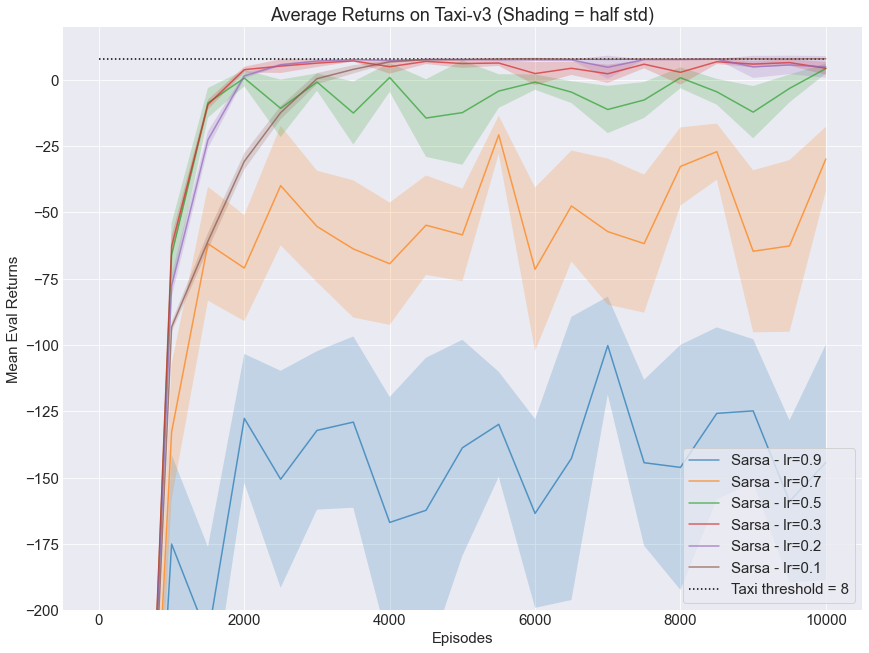

In [49]:
# plot returns of all learning rates next to each other
plt.figure(figsize=(12, 9))
axes = plt.gca()
plt.title(f"Average Returns on Taxi-v3 (Shading = half std)")

# draw goal line
x_min = 0
x_max = CONFIG["total_eps"]
plt.hlines(y=8, xmin=x_min, xmax=x_max, colors='k', linestyles='dotted', label="Taxi threshold = 8")
axes.set_ylim([-200,20])

for lr in LRs:
    returns_total, returns_std = results_dict[lr]
    plot_timesteps(CONFIG["eval_freq"], returns_total, returns_std/2, "Episodes", "Mean Eval Returns", f"Sarsa - lr={lr}")
plt.legend(loc="lower right", frameon=True, fancybox=True)
plt.show()